In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
plt.rcParams["figure.figsize"] = (4, 3)
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 13

# Prepare

In [3]:
from read_results import read_varnames
import saprc99_code.kpp4py as kpp

In [4]:
nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


In [5]:
df_range = pd.read_csv('saprc99_range.csv', index_col=0)
df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range.head(10)

,min,max,mid
H2SO4,2.131631e+10,1.223799e+12,6.225577e+11
HCOOH,1.941420e+10,1.137429e+11,6.657857e+10
CCO_OH,2.994973e+10,2.073705e+12,1.051827e+12
RCO_OH,1.275993e+10,1.380322e+12,6.965411e+11
CCO_OOH,8.695723e+05,1.215977e+12,6.079890e+11
RCO_OOH,4.160388e+05,7.387218e+11,3.693611e+11
XN,5.950410e+07,2.010207e+11,1.005401e+11
XC,4.906034e+12,5.593960e+12,5.249997e+12
SO2,8.404868e+05,1.202484e+12,6.012423e+11
O1D,1.000000e-08,7.012137e-01,3.506069e-01


# Sensitivity matrix on reference point

In [6]:
y0 = np.append(df_range['mid'], 0.5)
#y0 = np.random.uniform(np.append(df_range['min'], 0), np.append(df_range['max'], 1))

y0.shape

(75,)

In [7]:
f0 = kpp.onestep(y0.T).T
f0.shape

(1, 74)

In [8]:
y_perturb = np.empty([75, 75])
y_perturb[:] = y0
for i in range(75):
    y_perturb[i, i] *= 1.1

In [9]:
f = kpp.onestep(y_perturb.T).T
f.shape

(75, 74)

In [10]:
#A = f/f0 # sensitivity matrix
A = (f/y_perturb[:,:-1])/(f0/y0[:-1])

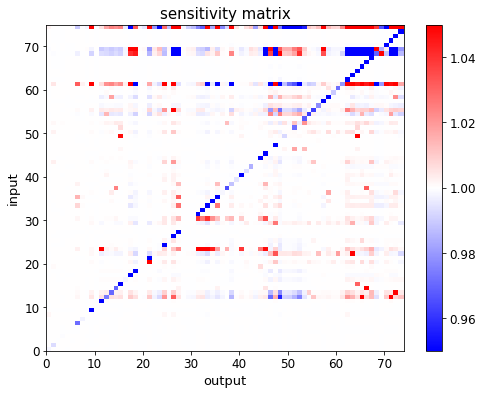

In [11]:
plt.figure(figsize=[8, 6])
plt.pcolormesh(A, cmap='bwr', vmin=0.95, vmax=1.05)
plt.colorbar()
plt.ylabel('input')
plt.xlabel('output')
plt.title('sensitivity matrix')

# Identify important input variable

In [12]:
# each output variable is impacted by how many input variables
for thres in [0.002, 0.01, 0.02, 0.05]:
    print(thres, '\n', (np.abs(A - 1.0) > thres).sum(axis=0))

0.002 
 [ 0  4  0  0  0  0  8  2  1  8  0 12 11 10 13 14  3 13 16  1  1 14  6 10 20
  1 24 15  1  2  2 12 13 18  8 15  3  5 14  3  7  3  5  5 12 17 19 22 23 13
 10 15 15 13 11  8  5  7 14  3  6  7 24 22 19 18 19 23 14  8 11 15 17 14]
0.01 
 [ 0  0  0  0  0  0  4  0  0  3  0  3  4  5  4  5  0  6  5  0  0  7  1  2  7
  1 10  9  0  0  1  4  4  6  4  8  1  3  6  0  3  0  2  1  3  7 10 10  9  4
  4 10  9  4  3  3  3  4  3  1  2  2  8  9  7  7  7 11  4  4  5  7  8  6]
0.02 
 [0 0 0 0 0 0 2 0 0 3 0 2 2 3 3 4 0 5 5 0 0 4 1 1 5 0 7 7 0 0 0 4 4 5 3 4 1
 1 3 0 2 0 0 0 2 6 7 7 8 1 2 4 5 3 1 1 1 4 1 0 1 2 7 6 7 6 7 5 4 3 3 6 7 3]
0.05 
 [0 0 0 0 0 0 0 0 0 3 0 2 0 0 0 1 0 4 3 0 0 3 0 1 2 0 6 4 0 0 0 2 2 4 1 3 0
 0 2 0 1 0 0 0 0 4 2 5 2 1 1 1 2 0 0 0 0 3 1 0 0 0 5 5 5 6 5 5 2 1 3 5 6 2]


In [13]:
# each input variable can impact how many output variables
for thres in [0.01, 0.02, 0.05]:
    print(thres, '\n', (np.abs(A - 1.0) > thres).sum(axis=1))

0.01 
 [ 0  0  0  0  0  0  1  0  0  1  0  1 19  6  2  2  0  1  1  0  2  1  5 14  1
  0  1  1  0  3 10  1  1  3  1  3  1  3  4  0  1  0  1  3  1  1  2  1  0  2
  1  1  3  1  8 12  1  1  6  1  1 35  1  1  1  1  1  1 29 31  1  1  1  1 51]
0.02 
 [ 0  0  0  0  0  0  1  0  0  1  0  1  9  3  2  2  0  1  1  0  1  1  2  9  1
  0  1  1  0  1  5  1  1  3  1  2  0  3  0  0  1  0  0  0  1  1  0  1  0  2
  0  1  1  1  3  6  1  1  2  0  1 30  1  1  1  1  1  1 21 22  1  1  1  1 41]
0.05 
 [ 0  0  0  0  0  0  0  0  0  1  0  1  2  1  1  1  0  1  1  0  1  1  0  4  1
  0  1  1  0  0  0  1  1  1  1  1  0  0  0  0  1  0  0  0  0  1  0  1  0  1
  0  0  0  0  0  1  0  1  1  0  0 19  1  1  1  1  1  1 14 16  1  1  1  1 27]


In [14]:
impact_factor = (np.abs(A - 1.0) > 0.02).sum(axis=1)
df_impact = pd.Series(impact_factor, index=varnames+['SUN'])

In [15]:
df_impact[df_impact>=5]

PAN      9
ARO2     9
ARO1     5
HCHO     6
O3      30
NO      21
NO2     22
SUN     41
dtype: int64

# Sensitivity on multiple points

In [16]:
def sensitivity(perb=1.1, thres=0.01):
    y0 = np.random.uniform(np.append(df_range['min'], 0), np.append(df_range['max'], 1))
    f0 = kpp.onestep(y0.T).T

    y_perturb = np.empty([75, 75])
    y_perturb[:] = y0
    for i in range(75):
        y_perturb[i, i] *= perb

    f = kpp.onestep(y_perturb.T).T

    A = f/f0 # sensitivity matrix
    
    n_effect = (np.abs(A - 1.0) > thres).sum(axis=0)
    return n_effect.mean(), n_effect.max()

In [17]:
%%time
n_max_ls = []
n_mean_ls = []

for i in range(200):
    n_mean, n_max = sensitivity()
    n_max_ls.append(n_max)
    n_mean_ls.append(n_mean)

CPU times: user 12.9 s, sys: 163 ms, total: 13.1 s
Wall time: 13.4 s


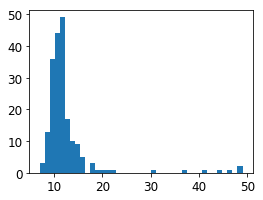

In [18]:
plt.hist(n_max_ls, bins=40);

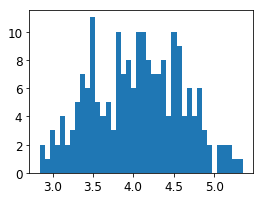

In [19]:
plt.hist(n_mean_ls, bins=40);